# Vectorizing backpropagation (in practice)

We've {ref}`already seen vectorized computational graphs in action <chapter:tensors/mlp>`, so we can easily recall that our layers take the form

$$
\tanh \big( X A \big), \quad X \in \mathbb{R}^{N \times n}, \quad A \in \mathbb{R}^{n \times m},
$$

where $ X \in \mathbb{R}^{N \times n} $ is the data matrix, and $ A \in \mathbb{R}^{n \times m} $ is the parameter matrix. In other words: vectorization is not enough; we need to *matricize*. (There's no such term as matricize, I just made that one up.)

Let's look at matrix addition: for any $ X, Y \in \mathbb{R}^{n \times m} $, their sum $ Z = X + Y \in \mathbb{R}^{n \times m} $ defines the familiar V-shaped graph:

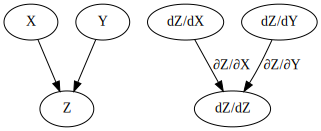

In [1]:
from graphviz import Digraph

digraph = Digraph()

nodes = ["X", "Y", "Z"]
edges = [("X", "Z"), ("Y", "Z")]
offset = " "

for v in nodes:
    digraph.node(v)
    digraph.node(v + offset, f"dZ/d{v}")

for u, v in edges:
    digraph.edge(u, v)
    digraph.edge(u + offset, v + offset, f"∂{v}/∂{u}")

digraph

What do $ \frac{dX}{dY} $ and $ \frac{\partial X}{\partial Y} $ mean?

Uh-oh. We have a snag. Following the logic of the Jacobian, these should be four-dimensional *tensors*:

$$
\frac{dX}{dY} = \bigg( \frac{dx_{i,j}}{dy_{k, l}} \bigg)_{i, j, k, l = 1, \dots, n} \in \mathbb{R}^{n \times n \times n \times n}, \quad \frac{\partial X}{\partial Y} = \bigg( \frac{\partial x_{i,j}}{\partial y_{k, l}} \bigg)_{i, j, k, l = 1, \dots, n} \in \mathbb{R}^{n \times n \times n \times n}.
$$

How do we multiply tensors?

We don't. Rather than spending blood, sweat, and tears to come up with how multidimensional matrices (a.k.a. tensors) are multiplied, we circumvent the problem.

## Computational graphs in practice

Fortunately, we can completely avoid working with matrix-matrix derivatives by noticing that the terminal node of our computational graphs in training is always a scalar: the loss function!

Take a look at multivariate linear regression:

$$
    \mathbf{p} = X A,
$$

where $ X \in \mathbb{R}^{N \times n} $ represents the data, $ A \in \mathbb{R}^{n \times m} $ encodes the parameters, and $ \mathbf{p} \in \mathbb{R}^{N \times m} $ contains the predictions. (Note that we have omitted the bias for simplicity; you can assume that the bias is included in $ A $ and $ X $ is augmented with a row of ones.)

With these in mind, the loss is defined by

$$
l = \frac{1}{N} \mathrm{sum}\Big( (\mathbf{y} - \mathbf{p})^2 \Big),
$$

where

* $ \mathbf{y} \in \mathbb{R}^{N \times m} $ is the ground truth,
* $ \mathbf{y} - \mathbf{p} $ is the *pointwise difference* of the two matrices,
* $ (\mathbf{y} - \mathbf{p})^2 $ is the pointwise square of the vector $ \mathbf{y} - \mathbf{p} $,
* and $ \mathrm{sum} \Big( (\mathbf{y} - \mathbf{p})^2 \Big) $ is the sum of the elements of $ (\mathbf{y} - \mathbf{p})^2 $.

All in all, $ l $ is a scalar! Here's the computational graph and its derivative:

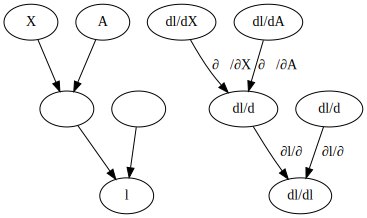

In [2]:
digraph = Digraph()

nodes = ["X", "A", "𝐩", "𝐲", "l"]
edges = [("X", "𝐩"), ("A", "𝐩"), ("𝐩", "l"), ("𝐲", "l")]
offset = " "

for v in nodes:
    digraph.node(v)
    digraph.node(v + offset, f"dl/d{v}")

for u, v in edges:
    digraph.edge(u, v)
    digraph.edge(u + offset, v + offset, f"∂{v}/∂{u}")


digraph

Look at the global derivatives: as the loss $ l \in \mathbb{R} $ is a scalar, global derivatives are all matrices: $ \frac{dl}{dX} \in \mathbb{R}^{N \times n} $, $ \frac{dl}{dA} \in \mathbb{R}^{n \times m} $, $ \frac{dl}{d\mathbf{p}} \in \mathbb{R}^{n \times 1} $, $ \frac{dl}{d\mathbf{y}} \in \mathbb{R}^{n \times 1} $, and $ \frac{dl}{dl} \in \mathbb{R} $. In other words, the global derivative of a node has the exact same shape as the node itself.

We cut off one head of the dragon, but what about the other? The local derivatives are still out of control: $ \frac{\partial \mathbf{p}}{\partial X} \in \mathbb{R}^{N \times N \times n} $ and $ \frac{\partial \mathbf{p}}{\partial X} \in \mathbb{R}^{N \times n \times m} $. Let's take a detailed look at what happens along the single edge $ X \to \mathbf{p} $. Hell, let's even write this out componentwise:

$$
\begin{bmatrix}
x_{1, 1} & x_{1, 2} & \dots & x_{1, n} \\
x_{2, 1} & x_{2, 2} & \dots & x_{2, n} \\
\vdots & \vdots & \ddots & \vdots \\
x_{N, 1} & x_{N, 2} & \dots & x_{N, n} \\
\end{bmatrix} \mapsto \begin{bmatrix}
p_{1, 1} & p_{1, 2} & \dots & p_{1, m} \\
p_{2, 1} & p_{2, 2} & \dots & p_{2, m} \\
\vdots & \vdots & \ddots & \vdots \\
p_{N, 1} & p_{N, 2} & \dots & p_{N, m} \\
\end{bmatrix}
$$

You can think about a $ p_{i, j} $ as the function of the elements of $ X $ element. We don't explicitly indicate this, but it's important.

During backpropagation, we take a step in the opposite direction, mapping the global derivative $ \frac{dy}{d\mathbf{p}} $ to $ \frac{dy}{dX} $:

$$
\begin{bmatrix}
\frac{dy}{dp_{1, 1}} & \frac{dy}{dp_{1, 2}} & \dots & \frac{dy}{dp_{1, m}} \\
\frac{dy}{dp_{2, 1}} & \frac{dy}{dp_{2, 2}} & \dots & \frac{dy}{dp_{2, m}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{dy}{dp_{N, 1}} & \frac{dy}{dp_{N, 2}} & \dots & \frac{dy}{dp_{N, m}} \\
\end{bmatrix} \mapsto \begin{bmatrix}
\frac{dy}{dx_{1, 1}} & \frac{dy}{dx_{1, 2}} & \dots & \frac{dy}{dx_{1, n}} \\
\frac{dy}{dx_{2, 1}} & \frac{dy}{dx_{2, 2}} & \dots & \frac{dy}{dx_{2, n}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{dy}{dx_{N, 1}} & \frac{dy}{dx_{N, 2}} & \dots & \frac{dy}{dx_{N, n}} \\
\end{bmatrix}.
$$

I know. That's a lot of derivatives. With the scalar version of the chain rule, we can express every single element of $ \frac{dy}{dX} $ by

$$
\frac{dy}{dx_{i, j}} = \sum_{k = 1}^{N} \sum_{l = 1}^{m} \frac{dy}{dp_{k, l}} \frac{\partial p_{k, l}}{\partial x_{i, j}}.
$$

Again, that's a lot of indices. Think of $ i $ and $ j $ as fixed, while $ k $ and $ l $ runs through all possible values.